# Galloway-Optimization Review

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm, ticker, colors
from scipy.constants import golden_ratio
from scipy.optimize import minimize


---
<img src='pics\p1.png'>

---

### Answer 01

##### Functions

In [103]:
def bisect_student(f,a,b,tol,rError = False):
    '''
    Desc: Perform basic bisection search algorithm
    Inputs:
        f: f(x) function with root between f(a) and f(b)
        a: Starting Lower Endpoint (must be to left of root)
        b: Starting Upper Endpoint (must be to right of root)
        tol: stopping tolerance
        rError: return error for iterations
    Output: 
        x at root, number of iterations
    '''
    MAX_ITER = 1000  # max number of iterations
    en = []
    # begin algorithm
    i = 0 # iteration counter
    while np.abs(b-a) > tol:
        c = (a+b)/2
        en.append(c)
        if f(c) > 0:
            a = a
            b = c
        else:
            a = c
            b = b
        i = i + 1
        if i >= MAX_ITER:
                # Convergence Failed, so Print Message
                raise Exception('Bisect: Failed to Converge in {:d} Interations'.format(MAX_ITER))
                return np.nan, MAX_ITER
    if rError:
        return c,i,np.abs(np.array(en) - c)
    else: return c,i


def golden_student(f,a,d,tol, GR = 1/golden_ratio,rError= False):
    '''
    Desc: Perform Basic Golden Section Search
    Inputs:
        f: f(x) function with root between f(a) and f(b)
        a: Starting Lower Endpoint (must be to left of root)
        d: Starting Upper Endpoint (must be to right of root)
        tol: stopping tolerance
        GR: golden ratio, optional overwrite
        rError: return error for iterations
    Output: 
        x at root, number of iterations
    '''
    MAX_ITER = 1000   # Max iterations
    
    #initialize
    b = (GR*a + (1.-GR)*d) 
    f1 = f(b)
    c = ((1.-GR)*a + GR*d)
    f2 = f(c)
    
    # begin algorithm
    i = 0 # iteration counter
    en = []
    while np.abs(d-a) > tol:
        en.append((a+d)/2)
        if f1 < f2:
            # move right bound
            d = c
            c = b
            f2 = f1
            b = GR*a + (1 - GR)*d
            f1 = f(b)
        else:
            # move left bound
            a = b
            b = c
            f1 = f2
            c = (1-GR)*a + GR*d
            f2 = f(c)
        i = i + 1
        if i >= MAX_ITER:
                # Convergence Failed, so Print Message
                raise Exception('GSS: Failed to Converge in {:d} Interations'.format(MAX_ITER))
                return np.nan, MAX_ITER
    ans = (a+d)/2
    if rError:
        return ans, i, np.abs(np.array(en) - ans)
    else:
        return ans, i

#### Perform Testing and Graph Results as Prescribed

In [104]:
'''Perform testing as described in problem statement'''
np.random.seed(42)  # for repeatability

N = 50 # Number of Trials

# build random arrays as perscribed
L = np.random.uniform(low = -10, high = 0, size = (N,))
U = np.random.uniform(low = 0, high = 10, size = (N,))
tol = np.linspace(1e-8,1,N)
gss_iter = np.zeros((N,))
bis_iter = np.zeros((N,))

# perform testing
for i,t in enumerate(tol):
    bs_avg = 0
    gss_avg = 0
    for k in range(0,N-1):
        bs_avg = bs_avg + bisect_student(lambda x: x*2, L[k], U[k], t)[1]
        gss_avg = gss_avg + golden_student(lambda x: x*x, L[k], U[k], t)[1]
    bis_iter[i] = bs_avg/N
    gss_iter[i] = gss_avg/N
    
# place in dataframe for qualitative verification and further manipulation
cols = ['Tolerance','Bisection Iterations','GSS Iterations']
p1_df = pd.DataFrame(np.stack((tol,bis_iter,gss_iter),axis=-1),columns=cols)
p1_df['Log10 Bisect'] = p1_df['Bisection Iterations'].apply(np.log10)
p1_df['Log10 GSS'] = p1_df['GSS Iterations'].apply(np.log10)
p1_df.head()

,Tolerance,Bisection Iterations,GSS Iterations,Log10 Bisect,Log10 GSS
0,1.000000e-08,29.72,42.58,1.473049,1.629206
1,2.040817e-02,9.18,12.96,0.962843,1.112605
2,4.081634e-02,8.20,11.56,0.913814,1.062958
3,6.122450e-02,7.58,10.76,0.879669,1.031812
4,8.163266e-02,7.22,10.14,0.858537,1.006038


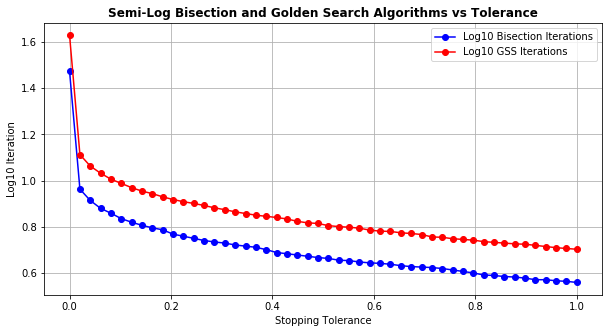

In [105]:
'''Graph as Directed'''
plt.figure(figsize=(10,5))
plt.plot(p1_df['Tolerance'], p1_df['Log10 Bisect'],'-ob',label='Log10 Bisection Iterations')
plt.plot(p1_df['Tolerance'], p1_df['Log10 GSS'],'-or',label='Log10 GSS Iterations')
plt.ylabel('Log10 Iteration')
plt.xlabel('Stopping Tolerance')
plt.title('Semi-Log Bisection and Golden Search Algorithms vs Tolerance',
         fontweight='bold')
plt.legend(loc='best')
_ = plt.grid()


####  Which algorithm performs best, and why?

The interval bisection method performs best.  Looking at the reduction in interval size per step, the bisection method reduces the interval by 50% per step, and the GSS only about 38% per step (or multiplication by the 1/golden ratio).  If we export the error for a run of each algorithm with identical parameters and fit a line to the decimal log of error followed by taking initial error and multiplying successively by these values and plotting the decimal log, the plots show the same slope as the algorithm produces for reducing error.  This seems to suggest that bisection is simply faster because 0.5 < 0.618.

In [106]:
'''Examining the Error Per Each Step for Both Algorithms'''
ibs_i, en_ibs = bisect_student(lambda x: x*2, -10, 9, 1e-6, rError=True)[1:]
gss_i, en_gss = golden_student(lambda x: x*x, -10, 9, 1e-6, rError=True)[1:]
ibs_mb = np.polyfit(range(0,ibs_i-2),np.log10(en_ibs[:-2]),1)
gss_mb = np.polyfit(range(0,gss_i-2),np.log10(en_gss[:-2]),1)

half_error = np.copy(en_ibs)
for i in range(1,len(half_error)):
    half_error[i] = half_error[i-1]*0.5
    
gss_error = np.copy(en_gss)
for i in range(1,len(gss_error)):
    gss_error[i] = gss_error[i-1]*(-1. + np.sqrt(5))/2


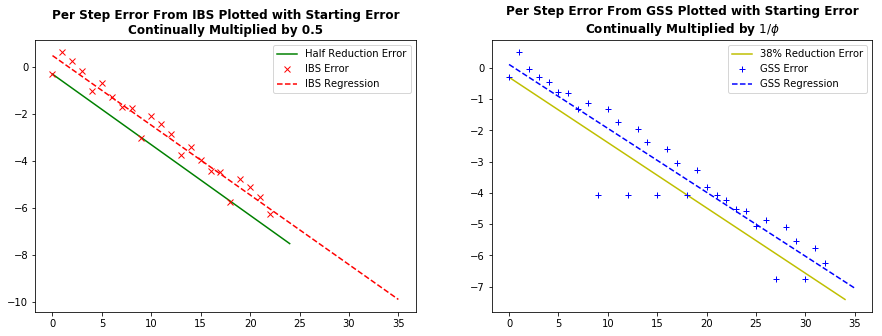

In [107]:
k = np.linspace(0,max(ibs_i,gss_i))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.log10(half_error),'g',label='Half Reduction Error')
plt.plot(np.log10(en_ibs[:-2]),'xr',label='IBS Error')
plt.plot(k,ibs_mb[0]*k + ibs_mb[1],'--r',label='IBS Regression')
plt.title('Per Step Error From IBS Plotted with Starting Error\nContinually Multiplied by 0.5',
         fontweight='bold')
_=plt.legend(loc='best')

plt.subplot(122)
plt.plot(np.log10(gss_error),'y',label='38% Reduction Error')
plt.plot(np.log10(en_gss[:-2]),'+b',label='GSS Error')
plt.plot(k,gss_mb[0]*k + gss_mb[1],'--b',label='GSS Regression')
plt.title('Per Step Error From GSS Plotted with Starting Error\nContinually Multiplied by $1/\phi$',
         fontweight='bold')
_=plt.legend(loc='best')


*Additional credit: Can you improve the GSS algorithm in this case? Consider modifying the GSS to reduce the average number of iterations. Change the golden ratio by +10% and -10%, and compare the average number of iterations to that of GSS as above. Plot the results for GSS in red, +10% in blue, and -10% in magenta. Which of these three methods performs best in this case, and why?*

The GSS algorithm can be improved by lowering the $1/\phi$ multiplier, as such we expect the raising of the golden ratio by 10% as directed to perform better than the implementation above since $\frac{1}{1.1*\phi} < \frac{1}{\phi} < \frac{1}{0.9*\phi}$. This should be able to be shown by analyzing the algorithm as an infinite series, but as requested, we proceed empirically.

In [108]:
'''Perform testing as described in problem statement'''
np.random.seed(42)  # for repeatability

N = 50 # Number of Trials

# build random arrays as perscribed
L = np.random.uniform(low = -10, high = 0, size = (N,))
U = np.random.uniform(low = 0, high = 10, size = (N,))
tol = np.linspace(1e-8,1,N)
gss_plus10 = np.zeros((N,))
gss_minus10 = np.zeros((N,))

# perform testing
for i,t in enumerate(tol):
    plus10_avg = 0
    minus10_avg = 0
    for k in range(0,N-1):
        plus10_avg = plus10_avg + golden_student(lambda x: x*x, L[k], U[k], t,
                                                 GR = 1/(1.1*golden_ratio))[1]
        minus10_avg = minus10_avg + golden_student(lambda x: x*x, L[k], U[k], t,
                                                  GR = 1/(0.9*golden_ratio))[1]
    gss_plus10[i] = plus10_avg/N
    gss_minus10[i] = minus10_avg/N
    
# place in dataframe for qualitative verification and further manipulation
cols = ['Tolerance','GSS Iterations','Golden Ratio +10% Iterations','Golden Ratio -10% Iterations']
p1a_df = pd.DataFrame(np.stack((tol,gss_iter,gss_plus10,gss_minus10),axis=-1),columns=cols)
p1a_df['Log10 GSS'] = p1a_df['GSS Iterations'].apply(np.log10)
p1a_df['Log10 GSS +10%'] = p1a_df['Golden Ratio +10% Iterations'].apply(np.log10)
p1a_df['Log10 GSS -10%'] = p1a_df['Golden Ratio -10% Iterations'].apply(np.log10)
p1a_df.head()

,Tolerance,GSS Iterations,Golden Ratio +10% Iterations,Golden Ratio -10% Iterations,Log10 GSS,Log10 GSS +10%,Log10 GSS -10%
0,1.000000e-08,42.58,36.00,51.04,1.629206,1.556303,1.707911
1,2.040817e-02,12.96,11.28,13.76,1.112605,1.052309,1.138618
2,4.081634e-02,11.56,10.08,12.12,1.062958,1.003461,1.083503
3,6.122450e-02,10.76,9.42,11.24,1.031812,0.974051,1.050766
4,8.163266e-02,10.14,8.92,10.52,1.006038,0.950365,1.022016


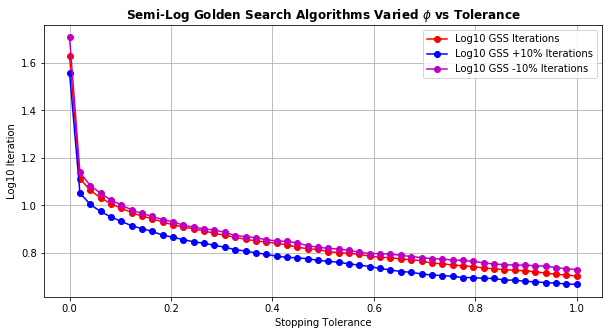

In [109]:
'''Graph as Directed'''
plt.figure(figsize=(10,5))
plt.plot(p1a_df['Tolerance'], p1a_df['Log10 GSS'],'-or',label='Log10 GSS Iterations')
plt.plot(p1a_df['Tolerance'], p1a_df['Log10 GSS +10%'],'-ob',label='Log10 GSS +10% Iterations')
plt.plot(p1a_df['Tolerance'], p1a_df['Log10 GSS -10%'],'-om',label='Log10 GSS -10% Iterations')
plt.ylabel('Log10 Iteration')
plt.xlabel('Stopping Tolerance')
plt.title('Semi-Log Golden Search Algorithms Varied $\phi$ vs Tolerance',
         fontweight='bold')
plt.legend(loc='best')
_ = plt.grid()

The results seem to confirm the intuition that the multiplier resulting in a greater per-step reduction in search space, namely $\frac{1}{1.1*\phi}$, converged with few iterations than both other multipliers.  In fact, the results match the ordering $\frac{1}{1.1*\phi} < \frac{1}{\phi} < \frac{1}{0.9*\phi}$ exactly.

---
<img src='pics\p2.png'>

---

## Answer Problem 2: 
### Part 1
Given $f(v) = (1 - v)^2$ for scalar $v \in \mathbb{R}$. By observation, this is a parabola with vertex at $v = 1$, which is convex for all $v$.

Confirming, 

$\frac{d f(v)}{dv} = 2v - 2$, which has one critical point at $ v = 1$, and $\frac{d^2 f(v)}{dv ^2} = 2$.  So, by the second derivative test, $f(v)$ has one critical point at $v=1$ and since the second derivative evaluated at that point is $\frac{d^2 f(1)}{dv ^2} = 2 > 0$ the single critical point is a minimum, and therefore a global minimum.  And, the function is convex everywhere.

### Part 2
If $g(v)$ and $h(v)$ are both convex functions than it must hold that the first derivative of both functions has one critical point and their second derivatives are positive for all $v$. 

Consider the sum as requested:

$f(v) = g(v) + h(v)$, then $\frac{d f(v)}{dv} = \frac{d g(v)}{dv} + \frac{d h(v)}{dv}$ and will have a single critical point, $v_c$ where $\frac{d g(v_c)}{dv} = - \frac{d h(v_c)}{dv}$. The second derivative $\frac{d^2 f(v)}{dv^2} = \frac{d^2 g(v)}{dv^2} + \frac{d^2 h(v)}{dv^2}$ will be positive everywhere since both $\frac{d^2 g(v)}{dv^2}, \frac{d^2 h(v)}{dv^2} > 0$ for all $v$ and their sum must therefore also be.

So, the sum of $g(v)$ and $h(v)$ is convex everywhere.

### Part 3

Given $g(v) = (a - v^2)^2$ for $a \in \mathbb{R}$ constant, and $v \in \mathbb{R}$ as before, then:

$\frac{d g(v)}{dv} = 4v(v^2 - a)$ having critical points at $v = 0, v^2 = a$. The second derivative, $\frac{d^2 g(v)}{dv^2} = 12v^2 - 4a$, is non-negative for $v^2 \ge \frac{a}{3}$.

So the convexity must be examined for 2 cases:
#### Case 1: $a \le 0$
The function is convex everywhere for values of $a \le 0$ in this case having one critical point at $v_c = 0$ and the second derivative being non-negative for $\frac{d^2 g(0)}{dv^2} = 12(0)^2 - 4a = -4a \ge 0,  \forall a \in (-\infty,0]$.  So the single critical point is a global minimum and a the function is convex everywhere in this case.

#### Case 2: $a > 0$
For the case where $a > 0$ the function is not convex everywhere.  There are 3 critical points at $v_c = 0, \pm \sqrt{a}$.  The second derivatives at these points are $\frac{d^2 g(0)}{dv^2} = - 4a, \frac{d^2 g(\pm \sqrt{a})}{dv^2} = 8a$.  So for $v_c = 0$ is a local maximum and $v_c = \pm \sqrt{a}$ are local minimums by the second derivative test. Thus,  for $a \gt 0$, the function is convex if the region is limited to either $v \in (-\infty,0]$ or $v \in [0,\infty)$, but not otherwise.

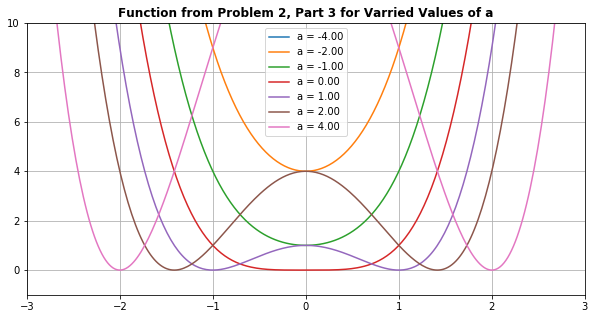

In [110]:
'''Visualize the Function For Varried Values of a'''
x = np.linspace(-10,10,num=1000)
plt.figure(figsize=(10,5))
for a in np.array([-4, -2,-1,0,1,2,4],dtype=float):
    fv = lambda v: (a - v*v)*(a-v*v)
    plt.plot(x,fv(x),label='a = {:0.2f}'.format(a))
plt.ylim((-1,10))
plt.xlim((-3,3))
plt.title('Function from Problem 2, Part 3 for Varried Values of a',
         fontweight='bold')
plt.legend(loc='best')
_=plt.grid()

### Part 4

For $\vec{v} = [v_1, v_2]^T$ given $p(\vec{v}) = (1-v_2)^2 + 100(v_2 - v_1^2)^2$,

The gradient is:
\begin{equation}
\nabla p(\vec{v}) = \begin{bmatrix} \frac{\partial p(\vec{v})}{\partial v_1} \\ \frac{\partial p(\vec{v})}{\partial v_2}\end{bmatrix} = \begin{bmatrix} 400v_1\left(v_1^2-v_2\right) \\ 202v_2-200v_1^2-2 \end{bmatrix}
\end{equation}
Solving for $\vec{0}$:
\begin{equation}
400v_1\left(v_1^2-v_2\right)   = 0 \implies v_1 = 0, v_1^2 = v_2 \\
202v_2-200v_1^2-2 = 0 \implies 202v_2 = 200v_1^2 + 2\\
\text{and, } 202v_2 \ne 200(0)^2 + 2, 202v_2 = 200(v_2) + 2
\end{equation}
So, the gradient has critical points on $\boxed{v_1^2 = v_2}$

The Hessian is:
\begin{equation}
\mathbb{H}\left(p(\vec{v})\right) = \begin{bmatrix} \frac{\partial^2 p(\vec{v})}{\partial v_1^2} && \frac{\partial^2 p(\vec{v})}{\partial v_1 v_2} \\ \frac{\partial^2 p(\vec{v})}{\partial v_2 v_1} && \frac{\partial^2 p(\vec{v})}{\partial v_2^2} \end{bmatrix} = \begin{bmatrix} 1200v_1^2-400v_2 && -400v_1 \\ -400v_1 && 202 \end{bmatrix}
\end{equation}
Applying the second partial derivative test:
\begin{equation}
det \bigg(\mathbb{H}\left(p(\vec{v})\right)\bigg) = 202*(1200v_1^2-400v_2) - 400^2v_1^2 \\
\text{and, } det \bigg(\mathbb{H}\left( [v_1,v_1^2]^T \right)\bigg) = 202*(1200v_1^2-400v_1^2) - 400^2v_1^2 \\
= (202*800 - 400^2)v_1^2 = \boxed{1600v_1^2 > 0, \forall v_1 \ne 0}\\
\end{equation}
Now, 
\begin{equation}
 \frac{\partial^2 p(\vec{v})}{\partial v_1^2} \Big\vert_{v_1^2 = v_2} = 1200v_1^2-400v_1^2 = \boxed{800v_1^2 > 0,  \forall v_1 \ne 0}
\end{equation}
So, by the second partial derivative test, we se that $p(\vec{v})$ has local minimums following the curve where $\boxed{v_1^2 = v_2}$ except possibly for $v_1 = 0$ for which the second partial derivative test is undefined.

By obersvation the function goes to $+ \infty$ at its extremes. Intuitively, this means that there is a hump in the surface in the region where $v_2 > v_1^2$ and the surface is not convex everywhere.

For convexity to hold, the Hessian must be positive semi-definite; so it must have non-negative, real eignevalues.  We will examine the system generally to double check what was found in the application of the second derivative test. Computing the eignevalues for the Hessian:

Characteristic equation,
\begin{equation}
det\begin{pmatrix}  \lambda - 1200v_1^2 + 400v_2  && -400v_1\\  -400v_1 &&  \lambda - 202\end{pmatrix} = \big( \lambda - 1200v_1^2 + 400v_2  \big) \big( \lambda - 202 \big) - (400^2 v_1^2) = 0 \\
\implies \lambda^2 - 1200v_1^2\lambda + 400v_2\lambda - 202\lambda + 202 \cdot 1200v_1^2 -202 \cdot 400 v_2 - 400^2 v_1^2 = 0 \\
\implies \lambda^2 + \lambda (400v_2- 1200v_1^2 - 202) + (202 \cdot 1200v_1^2 -202 \cdot 400 v_2 - 400^2 v_1^2) = 0
\end{equation}
Let, 
\begin{equation}
k_1 = 400v_2- 1200v_1^2 - 202\\
k_2 = 202 \cdot 1200v_1^2 -202 \cdot 400 v_2 - 400^2 v_1^2 \\
\implies \lambda = \frac{- k_1 \pm \sqrt{k_1^2 - 4k_2}}{2}
\end{equation}

#### Examining the eigenvalue space programatically 

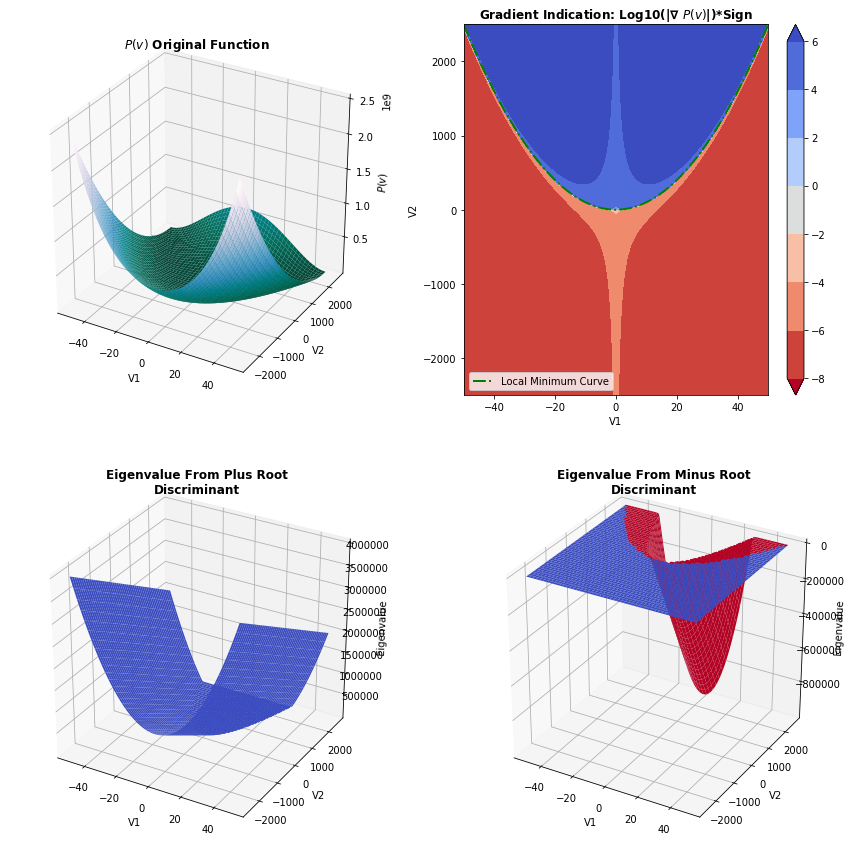

In [111]:
'''Plot Eigenvalues Space to Gain Insight'''
k1 = lambda v1,v2: 400*v2 - 1200*v1*v1 - 202
k2 = lambda v1,v2: 202*1200*v1*v1 -202*400*v2 - 400*400*v1*v1


N = 1000 # number of points
v1 = np.linspace(-50,50,N)
v2 = np.linspace(-50*50,50*50,N)
V1,V2 = np.meshgrid(v1,v2)
K1 = k1(V1,V2)
K2 = k2(V1,V2)

# Caculate Hessian Eigenvalues for Search Region
Lp = (-K1 + np.sqrt(K1*K1 - 4*K2))/2
Lm = (-K1 - np.sqrt(K1*K1 - 4*K2))/2

# Calculate Gradient Magnitude and Sign
Del_Pv1 = (400*V1*(V1*V1 - V2))
Del_Pv2 = (202*V2 - 200*V1*V1 - 2)
Del_P = np.log10(np.sqrt(Del_Pv1*Del_Pv1 + Del_Pv2*Del_Pv2))* np.sign(np.arctan2(Del_Pv2,Del_Pv1))

# Calculate the original function
Pv = (1-V2)*(1-V2) + 100*(V2 - V1*V1)*(V2 - V1*V1)



data = [Pv, Del_P, Lp,Lm]
title = ['$P(v)$ Original Function',
         'Gradient Indication: Log10(|\u2207 $P(v)$|)*Sign',
         'Eigenvalue From Plus Root\nDiscriminant',
         'Eigenvalue From Minus Root\nDiscriminant']
zlbl = ['$P(v)$','None','Eigenvalue','Eigenvalue']
vlims = [(None,None),(None,None),(-0.1,0),(-0.1,0)]
cmaps = [cm.PuBuGn_r,cm.coolwarm_r,cm.coolwarm_r,cm.coolwarm_r]

fig = plt.figure(figsize=(15,15))
for i,d in enumerate(data):
    if i == 1: 
        ax = fig.add_subplot(2,2,i + 1)
        cs = ax.contourf(V1,V2,Del_P,extend='both',cmap=cmaps[i])
        ax.plot(v1,v1*v1,'-.g',linewidth=2,label='Local Minimum Curve')
        ax.legend(loc='best')
        cbar = fig.colorbar(cs)
    else:
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        s = ax.plot_surface(V1,V2,d, cmap=cmaps[i],
                            vmin=vlims[i][0],vmax=vlims[i][1])
        ax.set_zlabel(zlbl[i])
    ax.set_title(title[i],fontweight='bold')
    ax.set_xlabel('V1')
    ax.set_ylabel('V2')


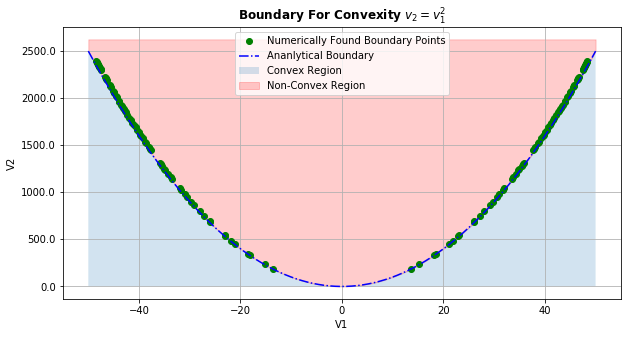

In [112]:
'''Examine region in 2d by filtering Hessian Eigenvalue results,
then plot against the analytical boundary'''
#Filter results to boundary
filt = np.where(np.logical_and(Lm > -0.05, Lm <= 0.05))

# perform regression
v12 = v1*v1

plt.figure(figsize=(10,5))
plt.plot(V1[filt],V2[filt],'og',label='Numerically Found Boundary Points')
plt.plot(v1,v12,'-.b',label='Ananlytical Boundary')
yt,yl = plt.yticks()
plt.fill_between(v1,v12,'b',alpha=0.2,label='Convex Region')
plt.fill_between(v1,v12,y2=plt.ylim()[-1],color='r',alpha=0.2,label='Non-Convex Region')
plt.yticks(ticks=yt[1:-1],labels=[str(j) for j in yt[1:-1]])
plt.title('Boundary For Convexity $v_2 = v_1^2$',fontweight='bold')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend(loc='best')
plt.grid()

The eigenvalue derived from adding the root of the discriminant appears to be a parabolic cylinder that is positive for all reals; however, the red shaded portion of the graph of the eigenvalue derived from subtracting the root of the discriminant is negative. So, in this region the Hessian is not positive semi-definite and the function is not convex. This region is bounded by the function $v_2 = v_1^2$.  Graphing the numerically found points agains the function created by the analytically found boundary confirms the findings.

Lack of convexity creates challeges in minimizing a function in that there is a risk of becoming caught in a local rather than global minimum, very slow convergence, or not converging at all.  Starting point selection and knowledge of the convergence domains is important in such a case.

---
<img src='pics\p3.png'>

## Answer 03

### Part 01

Generally, the Nelder-Mead algorithm provides a means of minimizing an objective function by iteratively moving, expanding, contracting or shrinking the simplex toward the lowest value of the function. A simplex is a polygon with $n+1$ vertices containing a subset of that which is covered by a function in $\mathbb{R}^n$ dimensions.  For example, in the compulsory $\mathbb{R}^2$ problem proposed, the simplex would take the form of a polygon with $2 +1 = 3$ vertices, or more plainly, a triangle.  The initial simplex is generated randomly or around a starting point depending on implementation.

Consider the $\mathbb{R}^2$ case as required. Let the simplex have vertices $\vec{v_1},\vec{v_2},\vec{v_3}$ and the objective function be denoted by $f(\vec{v})$.  The steps of the algorithm proceed as such for a single iteration:

1. Sort the verticies according to $f(\vec{v_1}) < f(\vec{v_2}) < f(\vec{v_3})$ where $f(\vec{v_3})$ is the highest value (and so the point farthest from the minimum).


2. Reflect the point farthest from the minimum, $f(\vec{v_3})$ in the preceeding ordering, about the centroid of all points except itself.  For the 2D case, the reflection point is simply the midpoint between $\vec{v_1}$ and $\vec{v_2}$, let this point be called $\vec{m}$.  Let the point resultant from this reflection be $\vec{r}$.


3. The function is evaluated at $f(\vec{r})$. This leads to several cases:
    1. If $\boxed{f(\vec{v_1}) < f(\vec{r}) \le f(\vec{v_2})}$, then the new simplex is formed of $\vec{r},\vec{v_1},\vec{v_2}$.  The algorithm now returns to step 1.
    2. If $\boxed{f(\vec{r}) < f(\vec{v_1})}$, the simplex is **Expanded** farther from the centroid than the initial reflection; let this point be called $\vec{e}$. Should $f(\vec{e}) < f(\vec{r})$, then the new simplex is formed of points $\vec{e},\vec{v_1},\vec{v_2}$. Otherwise, the new simplex is formed of $\vec{r},\vec{v_1},\vec{v_2}$.  The algorithm now returns to step 1.
    
    3. If $\boxed{f(\vec{v_1}) < f(\vec{r}) \le f(\vec{v_2})}$, the simplex is **Contracted** from the initial reflection point, $\vec{r}$, to a point between $\vec{m}$ and $\vec{r}$.  Let this new point be called $\vec{c}$. Now,
        1. If $\boxed{f(\vec{c}) < f(\vec{v_3})}$ the new simplex is formed from points $\vec{c},\vec{v_1},\vec{v_2}$ and the algorithm returns to step 1.
        2. If $\boxed{f(\vec{v_3}) \le f(\vec{c})}$, $\vec{v_2}$, and $\vec{v_3}$ are **Shrunk** fractionally toward $\vec{v_1}$.  Let these new shrunk points be $\vec{s_2}$ and $\vec{s_3}$.  The new simplex is comprised of points $\vec{v_1},\vec{s_2},\vec{s_3}$ and the algorithm returns to step 1.
4. Terminate the algorithm when the standard deviation, or variance of the function evaluated at the simplex vertices is less than a choosen tolerance.

### Part 02

#### Student CG and NM Implementation Functions


In [113]:
def Dim2_NelderMead(fun, x0, max_iter = 1000, tol=1e-16):
    '''Student Version of 2D Nelder-Mead/Downhill Simplex'''
    # Constants
    ALPHA = 1.0 # reflection constant
    GAMMA = 2.0 # expansion constant
    RHO = 0.5 # contraction constant
    SIGMA = 0.5 # shrinkage constant
    
    # Initialize the Simplex around Provided Start Point 
    # by method described in MATLAB fminsearch
    x = np.zeros((len(x0) + 1,len(x0)))
    x[0] = x0
    u = x0/np.linalg.norm(x0)
    for i,ui in enumerate(u):
        if np.abs(x0[i]) < tol:
            x[i+1] = x0 + 0.00025*ui
        else:
            x[i+1] = x0 + 0.05*ui
    
    y = np.zeros_like(x[:,0])
    s_idx = np.zeros_like(x[:,0])
    r,c = x.shape
    # evaluate inital simplex
    for j in range(r):
        y[j] = fun(x[j,:])
        
    # begin loop
    for i in range(0,max_iter):
        
        # sort function values
        s_idx = np.argsort(y) # returns ascending order

        # Check for Convergence or Max Iterations
        if (np.var(y) < tol):
            # return best value
            #print('Numer of iterations: ',i)
            return x[s_idx[0],:]
        
        # Reflect about centroid
        xm = 1/(r-1)*x[s_idx][0:r-1,:].sum(axis=0) # calculate Centroid
        xr = xm + ALPHA*(xm - x[s_idx[-1],:]) # reflected point
        yr = fun(xr)
        if (y[s_idx[0]] <= yr) and (yr < (y[s_idx[1]] )):
            # new function values is between the lowest two from prev iteration
            # update worst values and begin loop again
            y[s_idx[-1]] = yr
            x[s_idx[-1],:] = xr
            continue
        elif (yr < y[s_idx[0]]):
            # Expand simplex to new point bc it's the best
            xe = xm + GAMMA*(xr - xm) # expanded point
            ye = fun(xe)
            if (ye < yr):
                # expanded point is best so update worst
                # values and restart loop
                y[s_idx[-1]] = ye
                x[s_idx[-1],:] = xe
                continue
            else:
                # update worst point with reflected point
                y[s_idx[-1]] = yr
                x[s_idx[-1],:] = xr
                continue
        else:
            # reflected point is second best of the set
            # Contract Simplex
            xc = xm + RHO*(x[s_idx[-1],:] - xm)  # contraction point
            yc = fun(xc)
            
            if (yc < y[s_idx[-1]]):
                # Contracted point is better than worst so update and 
                # restart loop
                y[s_idx[-1]] = yc
                x[s_idx[-1],:] = xc
                continue
            else:
                # Shrink Simplex bc none of the points where better
                for k in range(r):
                    x[k,:] = x[s_idx[0],:] + SIGMA*(x[k,:] - x[s_idx[0],:])
    
    # exit on max iterations
    return x[s_idx[0],:]
        

'''Conjugate Gradient Methods'''
def student_grad(x):
    '''gradient from the equations of P2'''
    x02 = x[0]*x[0]
    return np.array([400*x[0]*(x02 - x[1]),
                    202*x[1] - 200*x02 - 2])
def student_hess(x):
    '''hessian from the equations of P2'''
    d = -400*x[0]
    return np.array([[1200*x[0]*x[0] - 400*x[1],d],
                     [d,202]])
    
def student_cg(grad, hess, x0, max_iter = 1000, tol = 1e-12):
    '''Student version of nonlinear Conjugate Gradient'''
    # initialize
    rn = -grad(x0)  # gradient
    pn = rn         # conjugate
    xn =  x0        # init x vars

    # begin loop
    for i in range(max_iter):
        # update step size
        if i == 0:
            an = 0 # use no step on init
        else:
            an = np.dot(rn,pn.T)/(np.dot(pn.T,np.dot(hess(xn),pn)))
    
        # update Step and get residual
        xnp1 = xn + an*pn
        rnp1 = -grad(xnp1)
                              
        # Fletcher-Reeves Method, update conjugate
        #bnp1 = np.dot(rnp1.T,rnp1)/np.dot(rn.T,rn)
        # Polak-Ribiere Method
        bnp1 = max(np.dot(rnp1.T,(rnp1 - rn))/np.dot(rn.T,rn),0)
        pn = rnp1 + bnp1*pn
    
        # update rn, xn
        rn = rnp1
        xn = xnp1
        
        # check tolerance
        if np.linalg.norm(rn) < tol:
            return xn                              

    # max iter reached
    return xn

### Optimization Method Comparison Calculations

In [114]:
'''Minimize the function in Problem 02 per Instructions'''
# Constants
LIM_V1 = (-3.,12.)
STEP_V1 = 0.1
LIM_V2 = (-6., 60.)
STEP_V2 = 1.
V_OPT = (1.,1.)

# Optimizer options
opt = {'maxiter':5}

# Create Grid of Starting Points
v_1 = np.arange(LIM_V1[0], LIM_V1[1] + STEP_V1, STEP_V1)
v_2 = np.arange(LIM_V2[0], LIM_V2[1] + STEP_V2, STEP_V2)

V_1,V_2 = np.meshgrid(v_1,v_2)   # initial guess grid
gs = V_1.shape                   # save grid shape

V_1, V_2 = V_1.flatten(), V_2.flatten()            # flatten arrays for looping
Znm, Zcg= np.zeros_like(V_1), np.zeros_like(V_1)   # Nelder-Mead, and Conjugate Gradient Results
Znm_s, Zcg_s = np.zeros_like(V_1), np.zeros_like(V_1)   # Nelder-Mead, and Conjugate Gradient Results Student 
Zcg_s20 = np.zeros_like(V_1)                            # Conjugate Gradient Results Student 

# Build Function
p = lambda x: (1-x[1])*(1-x[1]) + 100*(x[1] - x[0]*x[0])*(x[1] - x[0]*x[0])

# Perform Test at all Starting points
for i in range(0,len(V_1)):
    pnt = (V_1[i],V_2[i])
    
    # Get Euclidian Distance from Guess
    Znm[i] = np.linalg.norm(minimize(p, pnt, method='Nelder-Mead', options=opt).x - V_OPT)
    Zcg[i] = np.linalg.norm(minimize(p, pnt, method='CG', options=opt).x - V_OPT)
    Znm_s[i] = np.linalg.norm(Dim2_NelderMead(p, pnt, max_iter = 5) - V_OPT)
    Zcg_s[i] = np.linalg.norm(student_cg(student_grad,student_hess, pnt, max_iter = 5) - V_OPT)
    Zcg_s20[i] = np.linalg.norm(student_cg(student_grad,student_hess, pnt, max_iter = 20) - V_OPT)
    
    # Square Distance
    Znm[i] = Znm[i]*Znm[i]
    Zcg[i] = Zcg[i]*Zcg[i]
    Znm_s[i] = Znm_s[i]*Znm_s[i]
    
# Reshape Arrays to Grid
V_1, V_2 = V_1.reshape(gs), V_2.reshape(gs)
Znm, Zcg = Znm.reshape(gs), Zcg.reshape(gs)
Znm_s, Zcg_s = Znm_s.reshape(gs), Zcg_s.reshape(gs)
Zcg_s20 = Zcg_s20.reshape(gs)

### Plot Results of Various Algorithm'sConvergence from Compulsory Starting Points

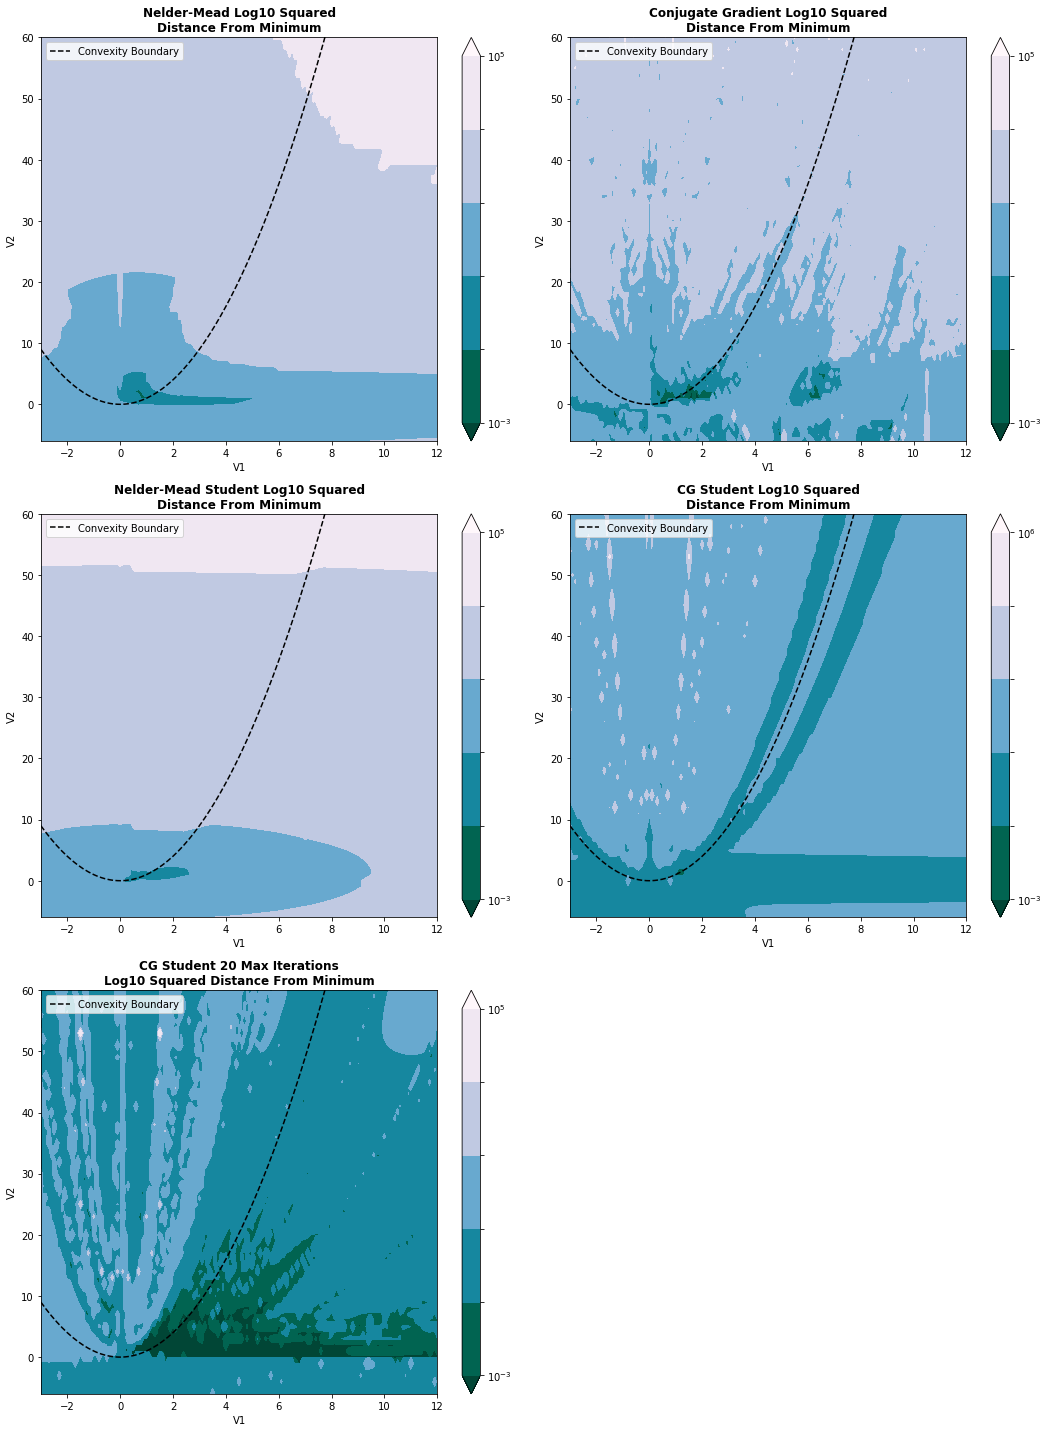

In [115]:
'''Plot Results'''
tol = 1e-3  #graphing zero tolerance
data = [Znm,Zcg,Znm_s,Zcg_s,Zcg_s20]
title = ['Nelder-Mead Log10 Squared\nDistance From Minimum',
         'Conjugate Gradient Log10 Squared\nDistance From Minimum',
        'Nelder-Mead Student Log10 Squared\nDistance From Minimum',
        'CG Student Log10 Squared\nDistance From Minimum',
        'CG Student 20 Max Iterations\nLog10 Squared Distance From Minimum']
fig = plt.figure(figsize=(15,20))
cmap = cm.get_cmap("winter")
cmap.set_under("magenta")
cmap.set_over("yellow")
for i,d in enumerate(data):
    ax = fig.add_subplot(3,2,i+1)
    levs = np.logspace(np.log10(tol),
                       np.ceil(np.log10(d.max())+1), 6)
    cs = ax.contourf(V_1, V_2, d, levs, extend='both',
                     norm=colors.LogNorm(),cmap=cm.get_cmap('PuBuGn_r'))
    ax.plot(v_1,v_1*v_1,'--k',label='Convexity Boundary')
    cbar = fig.colorbar(cs)
    ax.set_title(title[i],fontweight='bold')
    ax.set_xlim(LIM_V1)
    ax.set_ylim(LIM_V2)
    ax.set_xlabel('V1')
    ax.set_ylabel('V2')
    _ = ax.legend(loc='best')
plt.tight_layout()

#### Part 02: Discuss your findings.
As would be expected, both algorithms converge to a Euclidean distance closer to the machine zero when started in the region near the global minimum. In addition, in the region which we have found to be marked by lack of convexity, convergence is better when the starting point is in the positive $v_1$ space as would be expected since the $v_1$ gradient component is zero where $v_1 = 0$ (as shown in problem 02).  This portion of the space slopes toward the global minimum and has aided both algorithms.  Conversely, to the negative-side of $v_1$ the convergence for both algorithms doesn't perform as well due to the negative of the $v_1$ component's gradient pointing away from the global minimum.  This affects even the direct-search method as the function evaluations in this region will lead the algorithm down the "hill" and away from the global minimum.

The advantage of the conjugate gradient algorithm's directed gradient-based approach is clear as it has a larger region of closer to machine zero convergence.  Nelder-Mead has a region in which it did not seem to make progress toward the minimum at all toward the northeast corner of its contour plot. The non-uniformity of convergence in the conjugate gradient approach is due to the addition of calculating a step vector pointed at the center of its search subspace.  This allows for extremely quick convergence from more and varied starting points in the space. The Nelder-Mead algorithm has very uniform convergence regions as one would expect since the direct search method requires moving through each portion of the search space sequentially.

When comparing the python packages to the student's version of the algorithms, there are a few differences. For Nelder-Mead, the regions of convergence share a general similarity for the same topological reasons already outlined. The main variation is the shape of the regions.  This is most likely owning to the method of initialization for the starting simplex. There are several methods used and differences with essentaily generate differing starting points for the algorithm about the inital point $x_0$. As already pointed out, the direct search method is sensitive to starting point and the convergence domains show this.

For the student's conjugate gradient, the student version moved more quickly toward the minimum than its python counterpart.  This is likely due to the application of closed-form derivitives vesus the numerical solutions used for the packaged algorithm. The student version did not converge as well nearing the global minimum as the packaged version. Unit testing shows that with the addition of 10 to 20 more iterations, the student version does converge very well.  The difference is likely that the student's algorithm is calulating a step size slightly larger than the packed version. Since the packaged version will be using a umerical method to calculate $\alpha = argmin(\frac{\partial f(x_n + \alpha p_n)}{\partial \alpha})$, this suggests that the substitution of the hessian for the square, SPD matrix $A$ in the the purely linear application of conjugate gradient is regularly a larger approximation than numerical searching for the best $\alpha$.